In [106]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.preprocessing as preproc

In [6]:
dataset_root_path = 'feature_engineering/dataset/'

In [7]:
# 读取Yelp数据
biz_file = open(dataset_root_path + 'yelp_dataset/yelp_academic_dataset_business.json')
for each_line in biz_file.readlines():
    print(each_line)
    break

{"business_id":"6iYb2HFDywm3zjuRg0shjw","name":"Oskar Blues Taproom","address":"921 Pearl St","city":"Boulder","state":"CO","postal_code":"80302","latitude":40.0175444,"longitude":-105.2833481,"stars":4.0,"review_count":86,"is_open":1,"attributes":{"RestaurantsTableService":"True","WiFi":"u'free'","BikeParking":"True","BusinessParking":"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}","BusinessAcceptsCreditCards":"True","RestaurantsReservations":"False","WheelchairAccessible":"True","Caters":"True","OutdoorSeating":"True","RestaurantsGoodForGroups":"True","HappyHour":"True","BusinessAcceptsBitcoin":"False","RestaurantsPriceRange2":"2","Ambience":"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}","HasTV":"True","Alcohol":"'beer_and_wine'","GoodForMeal":"{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, '

In [8]:
biz_file = open(dataset_root_path + 'yelp_academic_dataset_business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_file.readlines()])
biz_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [9]:
biz_file.close()

In [10]:
biz_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [11]:
biz_df.shape

(160585, 14)

count    160585.000000
mean         51.964548
std         130.030448
min           5.000000
25%           8.000000
50%          17.000000
75%          44.000000
max        9185.000000
Name: review_count, dtype: float64


'\n点评数量横跨了多个数量级，对很多模型来说是不合适的\n在线性模型中同一线性系数应该对所有可能的数值起作用 出现少量巨大的数值会对模型造成破坏\n在K-means等无监督学习中，由于要计算欧氏距离 过大的数据会对欧氏距离的计算造成破坏\n'

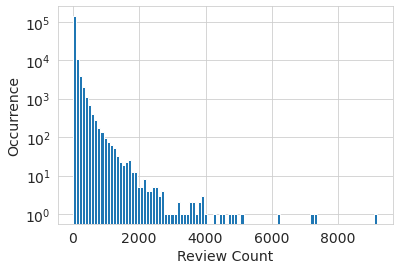

In [24]:
# 点评数量可视化

print(biz_df['review_count'].describe())

sns.set_style('whitegrid')                  # sns设定白色网格风格
fig,ax = plt.subplots()                     # subplots默认一个子图
biz_df['review_count'].hist(ax=ax, bins=100)# 对review_count列使用直方图(hist) 放在ax上 bin使用100个
ax.set_yscale('log')                        # 对y的取值取log
ax.tick_params(labelsize=14)                # 刻度值字体大小
ax.set_xlabel('Review Count', fontsize = 14)# 横轴名称
ax.set_ylabel('Occurrence', fontsize = 14)  # 纵轴名称

'''
点评数量横跨了多个数量级，对很多模型来说是不合适的
在线性模型中同一线性系数应该对所有可能的数值起作用 出现少量巨大的数值会对模型造成破坏
在K-means等无监督学习中，由于要计算欧氏距离 过大的数据会对欧氏距离的计算造成破坏
'''

区间量化（分箱）是解决方法
将数据分到多个箱子里，去掉实际的数值，将连续数值映射为离散型数值 这种离散值是一种有序的分箱序列，它表示的是对密度的测量
两个分箱方法：固定宽度分箱 / 自适应分箱

In [13]:
# ---------------------------------------------------固定宽度分箱

small_count = np.random.randint(0,100,20)
print(small_count)

[98 92 50 86 92 28  0 38 73 25 68 88  2 94 44 25 35 17 52 46]


In [14]:
# floor_divide API可以通过除法映射到间隔均分的分箱中
# floor_divide 返回小于等于除法结果的最大整数 所以可以用来分箱

print(np.floor_divide(small_count, 10))

[9 9 5 8 9 2 0 3 7 2 6 8 0 9 4 2 3 1 5 4]


In [15]:
# 通过log10取对数进行分箱
# np.floor是返回不大于输入参数的最大整数 可以用来分箱

large_counts = [296, 8286, 64011, 80, 3, 725, 867, 2215, 7689, 11495, 91897, 44, 28, 7971, 926, 122, 22222]
print(np.floor(np.log10(large_counts)))

[2. 3. 4. 1. 0. 2. 2. 3. 3. 4. 4. 1. 1. 3. 2. 2. 4.]


In [17]:
# --------------------------------------- 分位数分箱
# 固定宽度的分箱容易计算， 但是如果数值中有较大的缺口，就会产生很多没有使用的空箱子 可以根据数据自适应分箱

deciles = biz_df['review_count'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])
# quantile方法是一个分位函数方法 取分位数 0.1即为从小到大排列 10%的数据所在的位置的数值

print(deciles)


0.1      6.0
0.2      7.0
0.3      9.0
0.4     12.0
0.5     17.0
0.6     24.0
0.7     35.0
0.8     57.0
0.9    117.0
Name: review_count, dtype: float64


Text(0, 0.5, 'Occurrence')

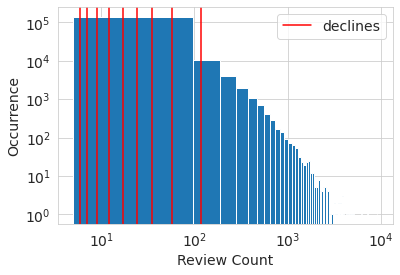

In [27]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
# biz_df['review_count'].hist(bins = 100)
biz_df['review_count'].hist(ax = ax, bins = 100)
for pos in deciles:
    handle = plt.axvline(pos, color='r')         # axvline纵向辅助线  axhline横向辅助线
ax.legend([handle],['declines'], fontsize = 14)  # legend 图例
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize = 14)
ax.set_ylabel('Occurrence', fontsize = 14)

In [34]:
# 使用pd.qcut可以直接将数值按照分位数切分 即切分的每一份内个数是一样的

cat = pd.qcut(large_counts, 4)
print('cat: ',cat)
print('-------------------------------------')
print('cat_value_count: ')
print(pd.value_counts(cat))

cat:  [(122.0, 926.0], (926.0, 8286.0], (8286.0, 91897.0], (2.999, 122.0], (2.999, 122.0], ..., (2.999, 122.0], (926.0, 8286.0], (122.0, 926.0], (2.999, 122.0], (8286.0, 91897.0]]
Length: 17
Categories (4, interval[float64, right]): [(2.999, 122.0] < (122.0, 926.0] < (926.0, 8286.0] < (8286.0, 91897.0]]
-------------------------------------
cat_value_count: 
(2.999, 122.0]       5
(122.0, 926.0]       4
(926.0, 8286.0]      4
(8286.0, 91897.0]    4
dtype: int64


In [36]:
# 计算实际的分位数值 使用quantile

large_count_series = pd.Series(large_counts)
print(large_count_series.quantile([0.25, 0.50, 0.75]))

0.25     122.0
0.50     926.0
0.75    8286.0
dtype: float64


Text(0, 0.5, 'log(x)')

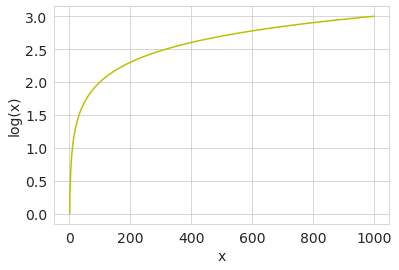

In [44]:
# 对数变换 -----------------------------------------------

x = range(1,1000)
y = np.log10(x)

fig, ax = plt.subplots()
plt.plot(x,y,'y')
ax.tick_params(labelsize=14)
ax.set_xlabel('x', fontsize = 14)
ax.set_ylabel('log(x)', fontsize = 14)

# 对数变换分析
对数函数可以对大数值的范围进行压缩， 对小数值的范围进行扩展 x越大，log(x)增长越慢
可以看到x<200仅占了x的20% 但是其log值却占了75%左右 将小的范围进行扩大
而x>500占了x的50%，其log值却仅仅只占了10%不到

**对于具有重尾分布的正数值的处理，对数变换是强大的工具** （重尾分布在尾部范围内的概率比高斯分布的概率大）它将分布在高端的长尾压缩成较短的尾部，并将低端扩展成较长的头部

In [53]:
def apply_log10(data):
    return np.log10(data + 1)

biz_df['log_review_count'] = biz_df['review_count'].apply(apply_log10)


Text(0, 0.5, 'occurrence')

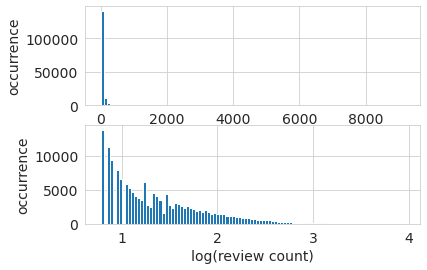

In [54]:
fig, (ax1, ax2) = plt.subplots(2,1)
biz_df['review_count'].hist(ax= ax1, bins = 100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('review count', fontsize = 14)
ax1.set_ylabel('occurrence', fontsize = 14)

biz_df['log_review_count'].hist(ax = ax2, bins = 100)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('log(review count)', fontsize = 14)
ax2.set_ylabel('occurrence', fontsize = 14)

# 可以看到 log方法将正数的重尾分布 变得更加均匀 在低数值集中的趋势被减弱了

In [55]:
online_news_data = pd.read_csv(dataset_root_path + 'OnlineNewsPopularity/OnlineNewsPopularity.csv')
online_news_data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


Text(0, 0.5, 'Number of Article')

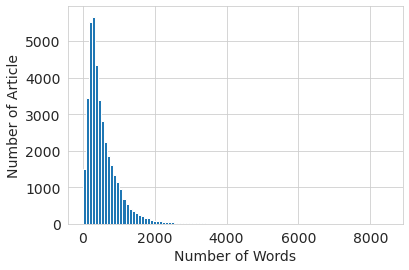

In [59]:
fig, ax = plt.subplots()
online_news_data[' n_tokens_content'].hist(ax = ax, bins = 100)
ax.tick_params(labelsize = 14)
ax.set_xlabel('Number of Words', fontsize = 14)
ax.set_ylabel('Number of Article', fontsize = 14)

# 我们可以看到 新闻中的字数是典型的重尾分布

In [61]:
online_news_data['log_n_tokens_content'] = online_news_data[' n_tokens_content'].apply(apply_log10)
print(online_news_data['log_n_tokens_content'].describe())

count    39644.000000
mean         2.557982
std          0.545231
min          0.000000
25%          2.392697
50%          2.612784
75%          2.855519
max          3.928140
Name: log_n_tokens_content, dtype: float64


Text(0, 0.5, 'Number of Article')

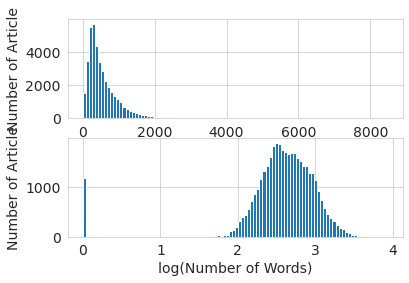

In [62]:
fig, (ax1, ax2) = plt.subplots(2,1)
online_news_data[' n_tokens_content'].hist(ax = ax1, bins = 100)
ax1.tick_params(labelsize = 14)
ax1.set_xlabel('Number of Words', fontsize = 14)
ax1.set_ylabel('Number of Article', fontsize = 14)

online_news_data['log_n_tokens_content'].hist(ax = ax2, bins = 100)
ax2.tick_params(labelsize = 14)
ax2.set_xlabel('log(Number of Words)', fontsize = 14)
ax2.set_ylabel('Number of Article', fontsize = 14)

# 通过log变换将其变为了类高斯分布 但是0位置除外

In [68]:
# 对数变换实战------------------------------------------------
# yelp数据集 通过点评数量预测商家的平均评分 由于评分是数值分布，所以用简单的线性回归即可
print(biz_df['review_count'].shape)
print(biz_df[['review_count']].shape)
print(type(biz_df['review_count']))
print(type(biz_df[['review_count']]))


m_orig = linear_model.LinearRegression()
score_orig = cross_val_score(m_orig, biz_df[['review_count']], biz_df['stars'], cv = 10) # 十折交叉验证 数据分为十份 每次取九份进行训练 一份进行测试 求平均值


m_log = linear_model.LinearRegression()
score_log = cross_val_score(m_log, biz_df[['log_review_count']], biz_df['stars'], cv = 10) # 这里包括了模型拟合训练的部分

print('R-squared score without log: {} (+/- {})'.format(score_orig.mean(),score_orig.std() * 2))
print('R-squared score with log: {} (+/- {})'.format(score_log.mean(), score_log.std() * 2))

# 总体而言使用了log对数变换后 使得效果变得好了一些

(160585,)
(160585, 1)
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
R-squared score without log: 0.0011312877051964266 (+/- 0.000499346239208769)
R-squared score with log: 1.186830474848577e-05 (+/- 0.0001639462865252219)


In [80]:
print(online_news_data.columns)

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [76]:
# 在线新闻流行度数据集 通过新闻的单词数量预测文章流行度 由于流行度(share)是数值分布，所以用简单的线性回归即可
print(online_news_data[' shares'].head())
print(online_news_data[' shares'].describe())

0     593
1     711
2    1500
3    1200
4     505
Name:  shares, dtype: int64
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64


In [78]:
print(online_news_data['log_n_tokens_content'].describe())

count    39644.000000
mean         2.557982
std          0.545231
min          0.000000
25%          2.392697
50%          2.612784
75%          2.855519
max          3.928140
Name: log_n_tokens_content, dtype: float64


In [81]:
m_orig_new = linear_model.LinearRegression()
score_orig_new = cross_val_score(m_orig_new, online_news_data[[' n_tokens_content']],online_news_data[' shares'], cv = 10)

m_log_new = linear_model.LinearRegression()
score_log_new = cross_val_score(m_log_new, online_news_data[['log_n_tokens_content']], online_news_data[' shares'], cv = 10)

print('R-squared score without log: {} (+/- {})'.format(score_orig_new.mean(),score_orig_new.std() * 2))
print('R-squared score with log: {} (+/- {})'.format(score_log_new.mean(), score_log_new.std() * 2))

# 使用log比不使用log好一点点

R-squared score without log: -0.0024246961830328706 (+/- 0.00508553965211169)
R-squared score with log: -0.0011448038627278722 (+/- 0.004180810975543767)


Text(13.175000000000004, 0.5, 'Number of Shares')

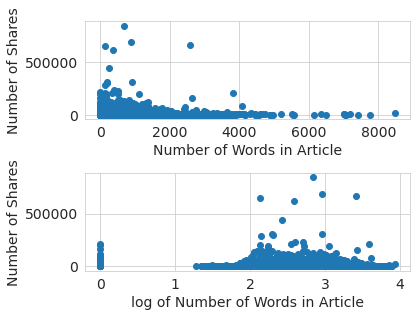

In [86]:
# 分析新闻数据集使用log变好的原因

fig2, (ax1, ax2) = plt.subplots(2,1)
# plt.subplots_adjust(hspace= 10)
plt.tight_layout()
ax1.scatter(online_news_data[' n_tokens_content'], online_news_data[' shares'])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Number of Words in Article', fontsize = 14)
ax1.set_ylabel('Number of Shares', fontsize = 14)

plt.tight_layout()  # 严格调整子图间距
ax2.scatter(online_news_data['log_n_tokens_content'], online_news_data[' shares'])
ax2.tick_params(labelsize=14)
ax2.set_xlabel('log of Number of Words in Article', fontsize = 14)
ax2.set_ylabel('Number of Shares', fontsize = 14)

# 可以看到不加以log时，在x较小的部分上，y值波动比较大， 可能x仅仅改变了10，y值就有上万的变化，而在x较大的部分 x的变化值很大y也可能没有什么变化 所以这并不符合线性模型的特点
# 在加以log之后， 改变了x轴 更多地聚集在x轴右侧， 或者说分布相对更加均匀， 这样在x变化差不多的时候，y的变化也差不多 将极端值非极端化了 所以更适合线性模型

In [87]:
biz_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'log_review_count'],
      dtype='object')

Text(13.175000000000004, 0.5, 'Stars')

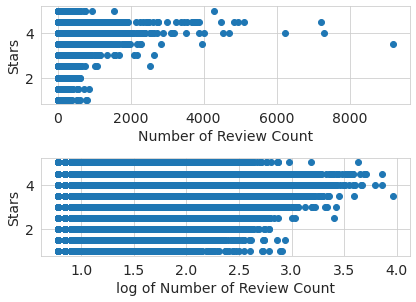

In [88]:
# 分析打分使用log变好的原因

fig2, (ax1, ax2) = plt.subplots(2,1)
# plt.subplots_adjust(hspace= 10)
plt.tight_layout()
ax1.scatter(biz_df['review_count'], biz_df['stars'])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Number of Review Count', fontsize = 14)
ax1.set_ylabel('Stars', fontsize = 14)

plt.tight_layout()  # 严格调整子图间距
ax2.scatter(biz_df['log_review_count'], biz_df['stars'])
ax2.tick_params(labelsize=14)
ax2.set_xlabel('log of Number of Review Count', fontsize = 14)
ax2.set_ylabel('Stars', fontsize = 14)

# 不论使用不适用log review count和start的关系绝非线性 不论低星高星 都会出现或多或少的review count

In [90]:
# BOX-COX变换是广义的平方根变换和对数变换
# BOX-COX的作用是将数据正态分布化
# BOX-COX只对正数有效果 如果不是正数 可以将其统一平移后处理

# 对yelp点评数量进行box-cox变换

from scipy import stats

print('review count min:',biz_df['review_count'].min())
# 确定最小值大于0 满足变换条件

rc_log = stats.boxcox(biz_df['review_count'], lmbda=0)
# 设置lmbda=0就是对数变换 log变换

rc_bc, bc_param = stats.boxcox(biz_df['review_count'])
# 如果不指定lmbda那么会自动寻找最优值
print(bc_param)


review count min: 5
-0.3466284691572269


In [92]:
print(type(rc_bc))
biz_df['rc_log'] = rc_log
biz_df['rc_bc'] = rc_bc

<class 'numpy.ndarray'>


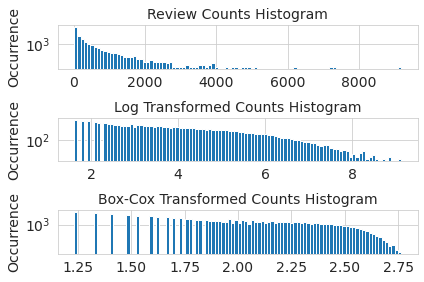

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
# original review count histogram
biz_df['review_count'].hist(ax=ax1, bins=100)
ax1.set_yscale('log')
ax1.tick_params(labelsize=14)
ax1.set_title('Review Counts Histogram', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence', fontsize=14)
plt.tight_layout()  # 严格调整子图间距


# review count after log transform
biz_df['rc_log'].hist(ax=ax2, bins=100)
ax2.set_yscale('log')
ax2.tick_params(labelsize=14)
ax2.set_title('Log Transformed Counts Histogram', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Occurrence', fontsize=14)
plt.tight_layout()  # 严格调整子图间距

# review count after optimal Box-Cox transform
biz_df['rc_bc'].hist(ax=ax3, bins=100)
ax3.set_yscale('log')
ax3.tick_params(labelsize=14)
ax3.set_title('Box-Cox Transformed Counts Histogram', fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Occurrence', fontsize=14)
plt.tight_layout()  # 严格调整子图间距

## 可以看到box cox将其正态分布化了

Text(0.5, 1.0, 'Probplot after Box-Cox transform')

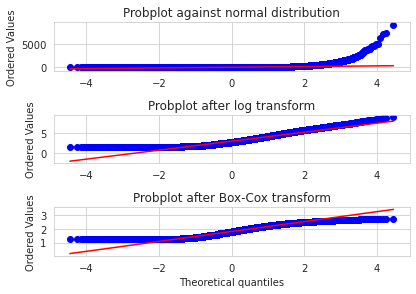

In [95]:
# 概率分布图 probplot 对比的是数据的实际分布与理论分布

fig2, (ax1, ax2, ax3) = plt.subplots(3,1)
prob1 = stats.probplot(biz_df['review_count'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
plt.tight_layout()  # 严格调整子图间距

prob2 = stats.probplot(biz_df['rc_log'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('')
ax2.set_title('Probplot after log transform')
plt.tight_layout()  # 严格调整子图间距

prob3 = stats.probplot(biz_df['rc_bc'], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_title('Probplot after Box-Cox transform')

# 可以看到通过box-cox的数据分布最接近于高斯分布

# 特征放缩/归一化
对于类似于拟合模型(线性回归等) 其受到输入数据的尺度影响很大
对于基于树的模型而言，输入尺度并没有什么关系
所以如果模型对输入尺度要求较高，就需要进行特征缩放(归一化)

## min-max缩放
x = x - min(x) / (max(x) - min(x))
[0,1]
## 特征标准化/方差缩放
x = x-mean(x) / sqrt(var(X)) 减去均值除以方差
均值为0 方差为1的高斯分布

## 不要中心化 稀疏数据
最小最大缩放和标准化都从原始特征值中减去一个数量。
对于最小最大缩放, 移动量是当前特征的所有值中最小的。对于标准化, 移动的量是平均值。
如果移动量不是零, 则这两种转换可以将稀疏特征（大部分值为零）的向量转换为一个稠密的向量。这反过来会给分类器带来巨大的计算负担, 取决于它是如何实现的。
会将稀疏的数据变得稠密 可能不是很多网络想要看到的

## l2归一化
使用l2范数进行归一化过程 x = x / ||x||2
经过l2归一化之后，特征的范数为1

**不论使用哪种缩放方法，也只是将原始数据平移后除以某常数(归一化常数)，因此不会改变特征分布的形状**

In [100]:
raw_n_tokens_content = online_news_data[' n_tokens_content'].to_numpy()
print(raw_n_tokens_content)
print(online_news_data[' n_tokens_content'].describe())

[219. 255. 211. ... 442. 682. 157.]
count    39644.000000
mean       546.514731
std        471.107508
min          0.000000
25%        246.000000
50%        409.000000
75%        716.000000
max       8474.000000
Name:  n_tokens_content, dtype: float64


In [101]:
# min-max缩放
online_news_data['minmax_of_n_tokens_content'] = preproc.minmax_scale(online_news_data[[' n_tokens_content']])
minmax_n_tokens_content = online_news_data['minmax_of_n_tokens_content'].to_numpy()
print(minmax_n_tokens_content)
print(online_news_data['minmax_of_n_tokens_content'].describe())

[0.02584376 0.03009205 0.02489969 ... 0.05215955 0.08048147 0.01852726]
count    39644.000000
mean         0.064493
std          0.055594
min          0.000000
25%          0.029030
50%          0.048265
75%          0.084494
max          1.000000
Name: minmax_of_n_tokens_content, dtype: float64


In [102]:
online_news_data['standardized_of_n_tokens_content'] = preproc.StandardScaler().fit_transform(online_news_data[[' n_tokens_content']])
standardized_n_token_content = online_news_data['standardized_of_n_tokens_content'].to_numpy()
print(standardized_n_token_content)
print(online_news_data['standardized_of_n_tokens_content'].describe())

# 标准化将方差定为1

[-0.69521045 -0.61879381 -0.71219192 ... -0.2218518   0.28759248
 -0.82681689]
count    3.964400e+04
mean    -6.742720e-17
std      1.000013e+00
min     -1.160078e+00
25%     -6.378980e-01
50%     -2.919004e-01
75%      3.597638e-01
max      1.682755e+01
Name: standardized_of_n_tokens_content, dtype: float64


In [103]:
online_news_data['l2_norm_of_n_tokens_content'] = preproc.normalize(online_news_data[[' n_tokens_content']],norm='l2',axis=0) # axis = 0是对feature进行norm axis = 是对sample进行norm
l2_norm_n_token_content = online_news_data['l2_norm_of_n_tokens_content'].to_numpy()
print(l2_norm_n_token_content)
print(online_news_data['l2_norm_of_n_tokens_content'].describe())

[0.00152439 0.00177498 0.00146871 ... 0.00307663 0.0047472  0.00109283]
count    39644.000000
mean         0.003804
std          0.003279
min          0.000000
25%          0.001712
50%          0.002847
75%          0.004984
max          0.058985
Name: l2_norm_of_n_tokens_content, dtype: float64


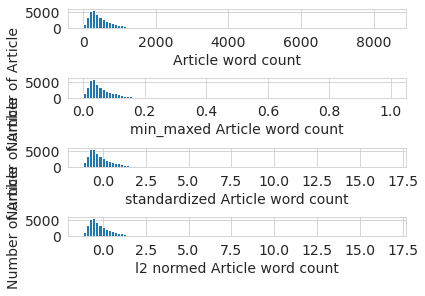

In [105]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.tight_layout()

online_news_data[' n_tokens_content'].hist(ax = ax1, bins = 100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Article word count', fontsize = 14)
ax2.set_ylabel('Number of Article', fontsize = 14)


online_news_data['minmax_of_n_tokens_content'].hist(ax = ax2, bins = 100)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('min_maxed Article word count', fontsize = 14)
ax2.set_ylabel('Number of Article', fontsize = 14)

online_news_data['standardized_of_n_tokens_content'].hist(ax = ax3, bins = 100)
ax3.tick_params(labelsize=14)
ax3.set_xlabel('standardized Article word count', fontsize = 14)
ax3.set_ylabel('Number of Article', fontsize = 14)

online_news_data['standardized_of_n_tokens_content'].hist(ax = ax4, bins = 100)
ax4.tick_params(labelsize=14)
ax4.set_xlabel('l2 normed Article word count', fontsize = 14)
ax4.set_ylabel('Number of Article', fontsize = 14)
plt.tight_layout()  # 严格调整子图间距

# 可以总结到 与对数变换不同 特征缩放不改变分布的形状， 只有数据尺度发生了变化
# 这是非常有用的 因为通常的数据都有多个feature，例如一个网站的访问量可能十几万次而购买量可能只有几万 所以当两个模型都被考虑时，访问量的影响力远大于购买量
# 如果不进行特征缩放 会对模型产生恶劣影响 而缩放后 则会使得模型更加稳定

In [ ]:
# 交互特征
# 两个特征的乘积可以组成简单的交互特征 即同时考虑多个特征的组合

In [107]:
online_news_data.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [124]:
features = [' n_tokens_title', ' n_tokens_content',
            ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
            ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
            ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
            ' data_channel_is_entertainment', ' data_channel_is_bus',
            ' data_channel_is_socmed', ' data_channel_is_tech',
            ' data_channel_is_world']
# 选出与内容有关的特征进行处理
X = online_news_data[features]
y = online_news_data[[' shares']]
print("X_shape: ", X.shape)
print("y_shape: ", y.shape)

X_shape:  (39644, 17)
y_shape:  (39644, 1)


In [125]:
X2 = preproc.PolynomialFeatures(include_bias=False).fit_transform(X) # PolynomialFeatures的作用是按照多项式进行交互特征生成
                                                                     # 原始数据[a,b] 结果为[1, a, b, a^2, ab, b^2] 将所有情况组合而成
print('X2_shape: ',X2.shape)

X2_shape:  (39644, 170)


In [126]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X,X2,y,test_size=0.3)

print('X1_train_shape: ',X1_train.shape)
print('X1_test_shape: ',X1_test.shape)
print('X2_train_shape: ',X2_train.shape)
print('X2_test_shape: ',X2_test.shape)
print('y_train_shape: ',y_train.shape)
print('y_test_shape: ',y_test.shape)

def evaluate_feature(X_train, X_test, y_train, y_test):
    model = linear_model.LinearRegression().fit(X_train,y_train)
    r_score = model.score(X_test, y_test)
    return model, r_score

X1_train_shape:  (27750, 17)
X1_test_shape:  (11894, 17)
X2_train_shape:  (27750, 170)
X2_test_shape:  (11894, 170)
y_train_shape:  (27750, 1)
y_test_shape:  (11894, 1)


In [127]:
m1, r1 = evaluate_feature(X1_train, X1_test, y_train, y_test)
m2, r2 = evaluate_feature(X2_train, X2_test, y_train, y_test)
print('R_square score of single feature: ',r1)
print('R_square score of pairwise features: ',r2)

# 使用交互特征可能比使用单个特征的效果更好

R_square score of single feature:  0.008608938712512115
R_square score of pairwise features:  0.011632293064023136
